In [198]:
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt
from matplotlib.offsetbox import AnchoredText
from matplotlib.ticker import MaxNLocator
import osmnx as ox
from urllib.request import urlopen
from shapely.geometry import Polygon, MultiPolygon,box

import contextily as ctx

gpd.options.use_pygeos = True

import time


## admin boundaries 
- data from NAMRIA as contributed by OCHA via HDX https://data.humdata.org/dataset/philippines-administrative-levels-0-to-3
- Creative Commons Attribution for Intergovernmental Organisations (CC BY-IGO) https://creativecommons.org/licenses/by/3.0/igo/
- make sure vector data has 'ADM3_EN','ADM2_EN','ADM1_EN' in its attributes

In [2]:
def load_adm_bounds(path,file):
    try:
        adm_gdf=gpd.read_file(path+file)
        adm_gdf=adm_gdf[['ADM3_EN','ADM2_EN','ADM1_EN','geometry']]
        return adm_gdf
    except:
        print("Error: File not found")
        return None

In [3]:
def get_target_admin(adm_gdf,lowest='province',get_defaults=True,region_ind=13,province_ind=1,muni_ind=1):

    regions=gpd.GeoDataFrame(np.sort(adm_gdf.ADM1_EN.unique()),columns=['regions'])
    if get_defaults==False:
        print("\n",regions)
        region_ind=int(input("Input integer index of target region: "))
    region=regions.values[region_ind][0]

    if lowest=='region':
        cur_adm=adm_gdf[(adm_gdf.ADM1_EN==region)]
        return cur_adm
    
    provinces=gpd.GeoDataFrame(np.sort(adm_gdf[adm_gdf.ADM1_EN==region].ADM2_EN.unique()),columns=['province'])
    if get_defaults==False:
        print("\n",provinces)
        province_ind=int(input("Input integer index of target province: "))
    province=provinces.values[province_ind][0]

    if lowest=='province':
        cur_adm=adm_gdf[(adm_gdf.ADM2_EN==province)]
        return cur_adm
        
    munis=gpd.GeoDataFrame(np.sort(adm_gdf[(adm_gdf.ADM1_EN==region) & (adm_gdf.ADM2_EN==province)].ADM3_EN.unique()),columns=['municipality'])
    if get_defaults==False:
        print("\n",munis)
        muni_ind=int(input("Input integer index of target municipality/city: "))
    muni=munis.municipality.values[muni_ind]

    cur_adm=adm_gdf[(adm_gdf.ADM2_EN==province) & (adm_gdf.ADM3_EN==muni)]

    return cur_adm

## NOAH landslide hazard map

In [4]:
def load_NOAH_LS_vector_list(path,file):
    lhaz_flist=[]
#     use local file
    try:
        lhaz_list=open(path+file,"r")
        
        for line in lhaz_list.readlines():
            if 'LANDSLIDE/vector' in line:
                fpath=line.split('.com/',)[-1]
                fpath=fpath.split('\n',)[0]
                lhaz_flist.append(fpath)
#     get from url
    except:
        print("Error: File not found....Reading from url...")
        lhaz_list=urlopen('https://raw.githubusercontent.com/maning/open-hazards-ph/master/noah.txt')
        for line in lhaz_list:
            if 'LANDSLIDE/vector' in line.decode('utf-8'):
                fpath=line.decode('utf-8').partition('B ')[-1:][0][:-1]
                lhaz_flist.append(fpath)
    lhaz_list.close()
    return pd.DataFrame(lhaz_flist)

In [5]:
def get_NOAH_LS_in_admin(flist,adm,lowest='province'):
    
    print(adm)
    
    if lowest=='muni':
        target_area=adm.ADM3_EN.values+", "+adm.ADM2_EN.values+", "+adm.ADM1_EN.values
    if lowest=='province':
        target_area=adm.ADM2_EN.values+", "+adm.ADM1_EN.values
    try:
        print("\n",flist[flist[0].str.contains(adm.ADM2_EN.values[0].replace(' ', ''),case=False)])
        lhaz_ind=int(input("\nInput integer index of landslide hazard map covering "+target_area[0]+'; "x" if none: '))
    except:
        print("\n",flist)
        lhaz_ind=int(input("\nInput integer index of landslide hazard map covering "+target_area[0]))
    
    try:
        start = time.time()
        lhaz_gdf = gpd.read_file(flist[flist.index==lhaz_ind].values[0][0])
        end = time.time()
        print("Lhaz layer loading took %f sec" % ((end - start) * 1.0))
        lhaz_in_adm=gpd.clip(lhaz_gdf,adm)
        
    except:
        print("Error: LH map not found....Reading from url...")
        start = time.time()
        lhaz_gdf = gpd.read_file("https://open-hazards-ph.s3.amazonaws.com/"+flist[flist.index==lhaz_ind].values[0][0])
        end = time.time()
        print("Lhaz layer loading took %f sec" % ((end - start) * 1.0))
        lhaz_in_adm=gpd.clip(lhaz_gdf,adm)
    
    return lhaz_in_adm

## OpenStreetMap road data

In [6]:
def get_roads_from_OSM(cur_adm, convex_hull=False):
    if convex_hull:
        graph=ox.graph.graph_from_polygon(cur_adm.dissolve().convex_hull.geometry.values[0], retain_all=True,network_type='all_private')
    else:
        graph=ox.graph.graph_from_polygon(cur_adm.dissolve().geometry.values[0], retain_all=True,network_type='all_private')
    return ox.utils_graph.graph_to_gdfs(graph, nodes=False).reset_index()

# Spatial overlay

In [7]:
def create_grid(area_gdf,num_grids=15):
    xmin, ymin, xmax, ymax =area_gdf.total_bounds
    xint=(xmax-xmin)/num_grids
    yint=(ymax-ymin)/num_grids

    cols = list(np.arange(xmin, xmax + xint, xint))
    rows = list(np.arange(ymin, ymax + yint, yint))

    polygons = []
    for x in cols[:-1]:
        for y in rows[:-1]:
            polygons.append(Polygon([(x,y), (x+xint, y), (x+xint, y+yint), (x, y+yint)]))
    return gpd.GeoDataFrame({'geometry':polygons})

In [201]:
def overlay_by_grid(vec1,vec2,grid):
    
    
    grid=grid.set_crs(vec1.crs)
    
    print("grids: ",len(grid))
    vec1_grids=[]
    
    for i in range(0,len(grid)):

        vec1_clip=gpd.clip(vec1,grid[grid.index==i])
        if len(vec1_clip)==0:
#             print(i, "no roads")
            continue
        vec2_clip=gpd.clip(vec2,grid[grid.index==i])

        try:
            start = time.time()
            vec1_grids.append(gpd.overlay(vec1_clip,vec2_clip,
                                          how='union',
                                          keep_geom_type=True).explode(index_parts=True))
            end = time.time()
            print(i, "current grid overlay took %f sec" % ((end - start) * 1.0))
        except:
#             print(i, "none, error overlay")
            continue

    vec1g=gpd.GeoDataFrame()
    for v in range(0,len(vec1_grids)):
        try:
            vec1g=vec1g.append(vec1_grids[v],ignore_index=True)
        except:
            continue
    return vec1g





# Plot and statistics

In [199]:
def plot_roadsLHonLHMap(LHmap,roads,adm,
                        alpha=0.3,lowest='province',
                        nxticks=3,nyticks=3):
#     some codes adopted from https://towardsdatascience.com/free-base-maps-for-static-maps-using-geopandas-and-contextily-cd4844ff82e1

    if lowest=='province':
        target_area=cur_adm.ADM2_EN.values+", "+cur_adm.ADM1_EN.values
    
    if lowest=='muni':
        target_area=cur_adm.ADM3_EN.values+", "+cur_adm.ADM2_EN.values+", "+cur_adm.ADM1_EN.values
    
    fig,ax=plt.subplots(figsize=(12,12))

    
    # get the uniques values in roads.LH
    LHlevels = np.sort(LHmap.LH.unique())
    # create a list for our custom colors
    c = ['g', 'y', 'r']
    colorDict = dict(zip(LHlevels,c))
    
    for LH, data in LHmap.groupby('LH'):
        color  = colorDict[LH]
        data.plot(ax=ax,color = color,alpha=alpha)
    
    # get the uniques values in roads.LH
    LHlevels = np.sort(roads.LH.unique())
    # create a list for our custom colors
    c = ['k','g', 'y', 'r']
    colorDict = dict(zip(LHlevels,c))
    
    
    for LH, data in roads.groupby('LH'):
        color  = colorDict[LH]
        data.plot(ax=ax,color = color, label = LH)
        
    ax.legend(title='landslide hazard', loc='best', prop={'size':15}) # set legend's position and size
    
    adm.plot(ax=ax,ec='b', fc='none')
    
    
    ax.ticklabel_format(useOffset=False, style='plain')
    
    copyright_text='Map data (c) Project NOAH,\nOpenStreetMap Contributors,\nOCHA Philippines'
    text_box = AnchoredText(copyright_text, frameon=True, loc=4, pad=0.25, borderpad=0.25)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    ax.add_artist(text_box)
    ax.set_title('Landslide hazard along roads\nin '+target_area[0],fontsize='xx-large')
    
    ax.yaxis.set_major_locator(MaxNLocator(nyticks))
    ax.xaxis.set_major_locator(MaxNLocator(nxticks))
    
    
    plt.savefig("map2.png",dpi=600)

In [200]:
def plot_roadsLHonBaseMap(adm,roads,basemap_url=ctx.providers.OpenStreetMap.Mapnik,
                          lowest='province',nxticks=3,nyticks=3):
#     some codes adopted from https://towardsdatascience.com/free-base-maps-for-static-maps-using-geopandas-and-contextily-cd4844ff82e1
    
    if lowest=='province':
        target_area=cur_adm.ADM2_EN.values+", "+cur_adm.ADM1_EN.values
    
    if lowest=='muni':
        target_area=cur_adm.ADM3_EN.values+", "+cur_adm.ADM2_EN.values+", "+cur_adm.ADM1_EN.values
    
    # get the uniques values in roads.LH
    LHlevels = np.sort(roads.LH.unique())
    # create a list for our custom colors
    c = ['k','g', 'y', 'r']
    # create a dictionary to combine both lists, categories are keys and # color codes are values
    colorDict = dict(zip(LHlevels,c))
    
    fig,ax=plt.subplots(figsize=(12,12))

    for LH, data in roads.groupby('LH'):
        color  = colorDict[LH]
        data.plot(ax=ax,color = color, label = LH)
        
    ax.legend(title='landslide hazard', loc='best', prop={'size':15}) # set legend's position and size
    
    adm.plot(ax=ax,ec='b', fc='none')
    
    try:
        ctx.add_basemap(ax, crs = adm.crs, url = basemap_url)
    except:
        basemap_err="online basemap not available this time"
        text_box = AnchoredText(basemap_err, frameon=True, loc=3, pad=0.25, borderpad=0.25)
        plt.setp(text_box.patch, facecolor='white', alpha=0.5)
        ax.add_artist(text_box)
        

    
    
    ax.ticklabel_format(useOffset=False, style='plain')
    
    copyright_text='Map data (c) Project NOAH,\nOpenStreetMap Contributors,\nOCHA Philippines'
    text_box = AnchoredText(copyright_text, frameon=True, loc=4, pad=0.25, borderpad=0.25)
    plt.setp(text_box.patch, facecolor='white', alpha=0.5)
    ax.add_artist(text_box)
    
    ax.set_title('Landslide hazard along roads\nin '+target_area[0],fontsize='xx-large')
    
    ax.yaxis.set_major_locator(MaxNLocator(nyticks))
    ax.xaxis.set_major_locator(MaxNLocator(nxticks))
    
    
    plt.savefig("map.png",dpi=600)

In [12]:
def assign_epsg(adm):    
#     EPSG:3121: PRS92 / Philippines zone 1 116.04, 6.21, 118.00, 18.64
#     EPSG:3122: PRS92 / Philippines zone 2 118.00, 3.02, 120.07, 20.42 
#     EPSG:3123: PRS92 / Philippines zone 3 119.70, 3.00, 122.21, 21.62 
#     EPSG:3124: PRS92 / Philippines zone 4 121.74, 3.44, 124.29, 22.18 
#     EPSG:3125: PRS92 / Philippines zone 5 123.73, 4.76, 126.65, 21.97
    epsg=[3121,3122,3123,3124,3125]
    
    bbox0=box(116.04, 6.21, 118.00, 18.64)
    bbox1=box(118.00, 3.02, 120.07, 20.42) 
    bbox2=box(119.70, 3.00, 122.21, 21.62) 
    bbox3=box(121.74, 3.44, 124.29, 22.18) 
    bbox4=box(123.73, 4.76, 126.65, 21.97)
    
    bbox=[bbox0,bbox1,bbox2,bbox3,bbox4]
    area_i=np.zeros(len(bbox))
    for b in range(len(bbox)):
        area_i[b]=adm.dissolve().geometry.intersection(bbox[b]).area
    return(epsg[np.argmax(area_i)])  

In [228]:
def plot_road_stats(gdf0,gdf,adm,
                    lowest='province',print_groups=False,
                    nxticks=4):
    
    print("OSM total length (km): ",gdf0['length'].sum().round(2))
    print("OSMxLH total length (km): ",gdf['length'].sum().round(2))
    print("Diff (%): ",(100*(gdf['length'].sum()-gdf0['length'].sum())/gdf0['length'].sum()).round(2))

    
    if lowest=='province':
        target_area=adm.ADM2_EN.values+", "+adm.ADM1_EN.values
    
    if lowest=='muni':
        target_area=adm.ADM3_EN.values+", "+adm.ADM2_EN.values+", "+adm.ADM1_EN.values
    
#     sort geodataframe according to highway tags as arranged in sorter
#     reference for geodataframe sorting solution from: https://stackoverflow.com/revisions/23483221/7

    sorter=['motorway','trunk','primary','secondary','tertiary','unclassified','residential',
            'path','track','footway','cycleway','service','steps','road']
    sorterIndex = dict(zip(sorter, range(len(sorter))))
    gdf['highway_Rank'] = gdf['highway'].map(sorterIndex)
    
#     classify roads with no names as 'unnamed'
    gdf['name']=gdf['name'].fillna('unnamed')
    
#     sort gdf according to highway sorter
    gdf=gdf.sort_values(['highway_Rank','name','LH'],ascending = [False, True, True])
    
#     remove LH=-1 for plotting
    gdf=gdf[gdf.LH!=-1]
    
#     set figure and axes
    m=1.5
    fig,ax=plt.subplots(nrows=1,ncols=2,figsize=(m*6,m*0.5*len(np.unique(gdf.highway.values))))
    
    
    fig.add_subplot(111, frameon=False)
    # hide tick and tick label of the big axes
    plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
    plt.grid(False)
    plt.xlabel("road length, km", fontsize='xx-large')
#     plt.ylabel("common Y")
    plt.title('Roads and landslide hazards \nin '+target_area[0],fontsize='xx-large')
    
    
#     groupby LH
    
    g0=gdf[['LH','length']].groupby(by=['LH'],sort=False).sum()
    g0['length'].plot.barh(ax=ax[0],color=['g','y','r'])
#     ax[0].set_title('roads by landslide hazard',fontsize='x-large')
    ax[0].set_ylabel('landslide hazard',fontsize='x-large')
    ax[0].set_yticklabels(ax[0].get_yticklabels(),fontsize='xx-large')
    ax[0].xaxis.set_major_locator(MaxNLocator(nxticks,integer=True))
    
#     ax[0].set_xlabel("total length, km",fontsize='x-large')
    if print_groups:
        print(g0.round(2),"\n",g0.sum().round(2))
    
#     groupby highway tag, LH
    g1=gdf[['highway','LH','length']].groupby(by=['highway','LH'],sort=False).sum()
    g1['length'].unstack().plot.barh(ax=ax[1],color=['g','y','r'])
#     ax[1].set_title('roads by highway tag\nand landslide hazard',fontsize='x-large')
    ax[1].set_ylabel(None)
    ax[1].set_yticklabels(ax[1].get_yticklabels(),fontsize='x-large')
#     ax[1].set_xlabel("total length, km",fontsize='x-large')
    ax[1].yaxis.set_label_position("right")
    ax[1].yaxis.tick_right()
    ax[1].invert_xaxis()
    ax[1].xaxis.set_major_locator(MaxNLocator(nxticks,integer=True))
    
    
    if print_groups:
        print(g1.round(2),"\n",g1.sum().round(2))
    
    plt.tight_layout()
    plt.savefig("stat_plot.png",dpi=300)

In [13]:
def clean_list_types(gdf):
    
    for cols in gdf.columns:
        if cols=='geometry':continue
        gdf[cols]=gdf[cols].apply(pd.Series)[0]#removes list type in column 'name', and replaces it with the first element of that list t list 

    return gdf

# Load administrative boundaries

In [14]:
# define local paths and filenames
admin_path="/home/ozned/Dropbox/JUN-Main/GIS/GIS-source-files/vector/phl_adm_psa_namria_20200529_shp/"
admin_file="phl_admbnda_adm3_psa_namria_20200529.shp"

NOAH_path="/home/ozned/Git/lslideXroads/noah/LANDSLIDE/vector/"
NOAH_file_filelist="file_list.txt"


adm_gdf=load_adm_bounds(admin_path,admin_file)
NOAH_LS_vectors=load_NOAH_LS_vector_list(NOAH_path,NOAH_file_filelist)

# Extract admin boundaries, LH, and roads

In [224]:
lowest='province'
get_defaults=False
cur_adm=get_target_admin(adm_gdf,lowest=lowest,get_defaults=get_defaults)
lhaz_in_adm=get_NOAH_LS_in_admin(NOAH_LS_vectors,cur_adm.dissolve(),lowest=lowest)
roads=get_roads_from_OSM(cur_adm, convex_hull=False)
roads=roads[['u', 'v', 'key', 'osmid', 'name', 'highway','geometry']]

# # test plot
# lhaz_in_adm.plot()
# cur_adm.plot(ax=plt.gca(),fc='none',ec='r')
# roads.plot(ax=plt.gca(),ec='k')



                                  regions
0   Autonomous Region in Muslim Mindanao
1       Cordillera Administrative Region
2                National Capital Region
3                               Region I
4                              Region II
5                             Region III
6                            Region IV-A
7                            Region IV-B
8                              Region IX
9                               Region V
10                             Region VI
11                            Region VII
12                           Region VIII
13                              Region X
14                             Region XI
15                            Region XII
16                           Region XIII
Input integer index of target region: 7

              province
0          Marinduque
1  Occidental Mindoro
2    Oriental Mindoro
3             Palawan
4             Romblon
Input integer index of target province: 0
                                            

/home/ozned/miniconda3/envs/gis/lib/python3.9/site-packages/osmnx/utils_geo.py:335: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for polygon in geometry:
/home/ozned/miniconda3/envs/gis/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:
/home/ozned/miniconda3/envs/gis/lib/python3.9/site-packages/osmnx/utils_geo.py:426: ShapelyDeprecationWarning: Iteration over multi-part geometries is deprecated and will be removed in Shapely 2.0. Use the `geoms` property to access the constituent parts of a multi-part geometry.
  for poly in multipoly:


<AxesSubplot:>

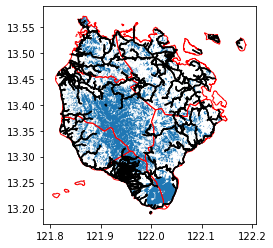

In [225]:
# test plot
lhaz_in_adm.plot()
cur_adm.plot(ax=plt.gca(),fc='none',ec='r')
roads.plot(ax=plt.gca(),ec='k')

# Overlay operations

In [226]:
grid=create_grid(cur_adm,30)
start = time.time()
roads_gr=overlay_by_grid(roads,lhaz_in_adm,grid)
end = time.time()
print("total grid overlay took %f sec" % ((end - start) * 1.0))

roads_gr=clean_list_types(roads_gr)
roads_gr['LH']=roads_gr.LH.fillna(-1).astype(int)

epsg=assign_epsg(cur_adm)
roads['length']=roads.to_crs(epsg=epsg).geometry.length/1000.
roads_gr['length']=roads_gr.to_crs(epsg=epsg).geometry.length/1000.

grids:  930
19 current grid overlay took 0.034170 sec
21 current grid overlay took 0.039537 sec
43 current grid overlay took 0.036458 sec
44 current grid overlay took 0.042141 sec
45 current grid overlay took 0.039105 sec
46 current grid overlay took 0.048520 sec
47 current grid overlay took 0.037206 sec
48 current grid overlay took 0.036659 sec
49 current grid overlay took 0.057019 sec
50 current grid overlay took 0.053213 sec
51 current grid overlay took 0.044570 sec
52 current grid overlay took 0.039766 sec
53 current grid overlay took 0.032831 sec
73 current grid overlay took 0.033102 sec
74 current grid overlay took 0.056610 sec
75 current grid overlay took 0.036986 sec
76 current grid overlay took 0.051414 sec
77 current grid overlay took 0.041200 sec
78 current grid overlay took 0.039380 sec
81 current grid overlay took 0.053884 sec
82 current grid overlay took 0.078282 sec
83 current grid overlay took 0.041231 sec
84 current grid overlay took 0.035710 sec
85 current grid overla

406 current grid overlay took 0.060062 sec
407 current grid overlay took 0.059191 sec
408 current grid overlay took 0.049528 sec
409 current grid overlay took 0.116037 sec
410 current grid overlay took 0.169403 sec
411 current grid overlay took 0.076535 sec
415 current grid overlay took 0.039627 sec
420 current grid overlay took 0.089530 sec
421 current grid overlay took 0.066591 sec
422 current grid overlay took 0.066172 sec
423 current grid overlay took 0.042162 sec
424 current grid overlay took 0.039351 sec
426 current grid overlay took 0.042404 sec
427 current grid overlay took 0.045464 sec
428 current grid overlay took 0.035607 sec
435 current grid overlay took 0.037323 sec
436 current grid overlay took 0.045151 sec
438 current grid overlay took 0.062961 sec
439 current grid overlay took 0.040772 sec
440 current grid overlay took 0.067289 sec
442 current grid overlay took 0.044527 sec
443 current grid overlay took 0.041456 sec
445 current grid overlay took 0.080353 sec
446 current

764 current grid overlay took 0.036878 sec
765 current grid overlay took 0.042487 sec
770 current grid overlay took 0.036112 sec
771 current grid overlay took 0.032116 sec
787 current grid overlay took 0.031808 sec
788 current grid overlay took 0.034519 sec
789 current grid overlay took 0.033492 sec
790 current grid overlay took 0.031608 sec
795 current grid overlay took 0.032056 sec
801 current grid overlay took 0.035511 sec
802 current grid overlay took 0.033356 sec
820 current grid overlay took 0.030869 sec
893 current grid overlay took 0.031253 sec
894 current grid overlay took 0.031627 sec
924 current grid overlay took 0.034133 sec
925 current grid overlay took 0.029904 sec
total grid overlay took 46.754393 sec


/home/ozned/miniconda3/envs/gis/lib/python3.9/site-packages/pygeos/set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/tmp/ipykernel_149301/2796348786.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_i[b]=adm.dissolve().geometry.intersection(bbox[b]).area
/home/ozned/miniconda3/envs/gis/lib/python3.9/site-packages/pygeos/set_operations.py:129: RuntimeWarning: invalid value encountered in intersection
  return lib.intersection(a, b, **kwargs)
/tmp/ipykernel_149301/2796348786.py:18: UserWarning: Geometry is in a geographic CRS. Results from 'area' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  area_i[b]=adm.dissolve().geometry.intersection(bbox[b]).area
/tmp/ipykernel_149301/2796348786.py:18: UserWarning:

# compute statistics, and plot

OSM total length (km):  2196.64
OSMxLH total length (km):  2196.64
Diff (%):  0.0


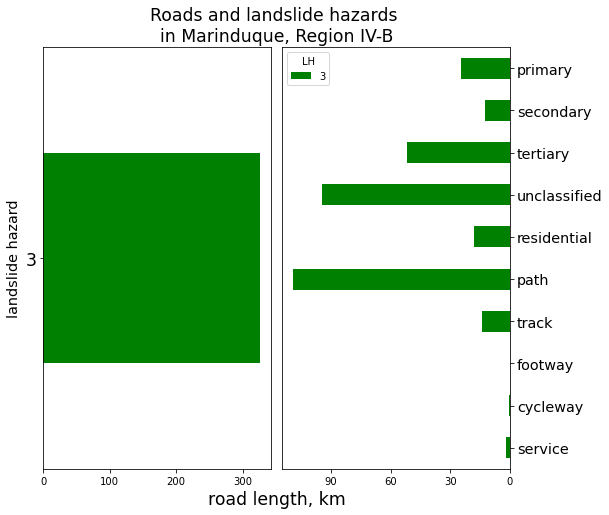

In [229]:
# fill highway column with no data based on https://wiki.openstreetmap.org/wiki/Tag:highway%3Droad
roads_gr['highway']=roads_gr.highway.fillna('road')
plot_road_stats(roads,roads_gr,cur_adm,lowest=lowest)

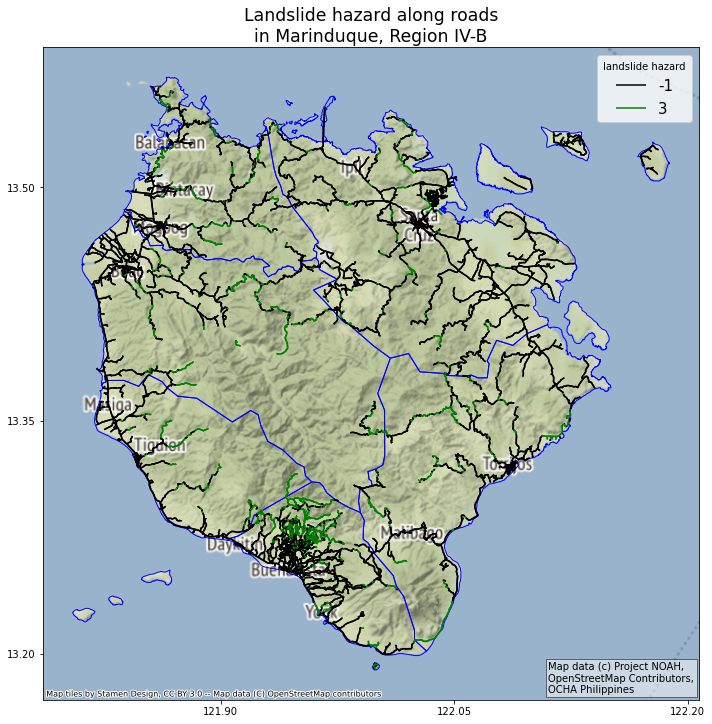

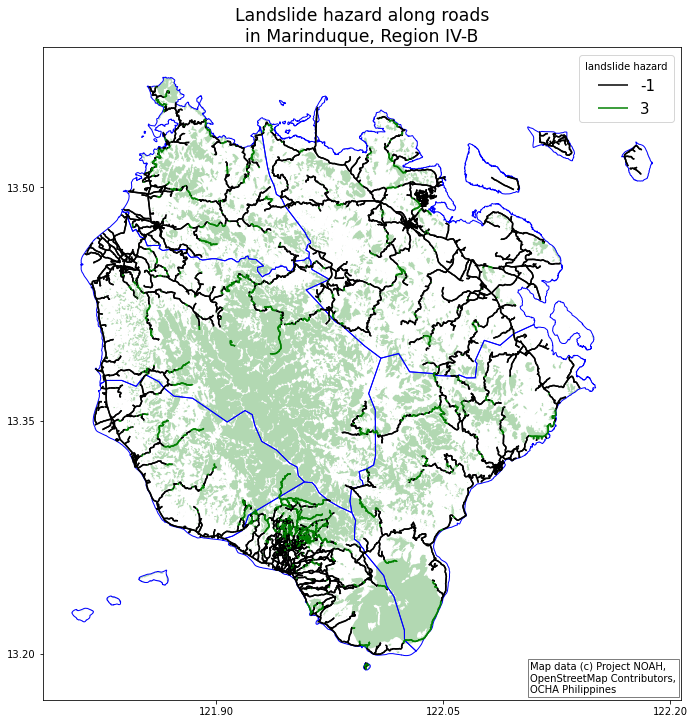

In [230]:
# print(ctx.providers.keys())
# print(ctx.providers.OpenStreetMap.keys())

basemap_url=ctx.providers.OpenStreetMap.Mapnik
plot_roadsLHonBaseMap(cur_adm,roads_gr,basemap_url,lowest=lowest)
plot_roadsLHonLHMap(lhaz_in_adm,roads_gr,cur_adm,alpha=0.3,lowest=lowest)

# export to geopackage

In [217]:
roads_gr.to_file("roads_LH.gpkg",driver="GPKG")
lhaz_in_adm.to_file("noah_LH.gpkg",driver="GPKG")

# END CODE

# data sources

### NOAH landslide hazard vector files
- data source: Project NOAH http://noah.up.edu.ph
- data hosted at https://github.com/maning/open-hazards-ph 
- license:  Open Data Commons Open  Database License (ODC-ODbL) https://open-hazards-ph.s3.amazonaws.com/noah/license.pdf, https://opendatacommons.org/licenses/odbl/1-0/
    - You are free:

        - To share: To copy, distribute and use the database.
        - To create: To produce works from the database.
        - To adapt: To modify, transform and build upon the database.

    - As long as you:

        - Attribute: You must attribute any public use of the database, or works produced from the database, in the manner specified in the ODbL. For any use or redistribution of the database, or works produced from it, you must make clear to others the license of the database and keep intact any notices on the original database.
        - Share-Alike: If you publicly use any adapted version of this database, or works produced from an adapted database, you must also offer that adapted database under the ODbL.
        - Keep open: If you redistribute the database, or an adapted version of it, then you may use technological measures that restrict the work (such as DRM) as long as you also redistribute a version without such measures.


### Administrative boundaries 
- data source: NAMRIA and PSA
- data contributed by: OCHA Philippines https://data.humdata.org/organization/27fbd3ff-d0f4-4658-8a69-a07f49a7a853
- data hosted in HDX, https://data.humdata.org/dataset/philippines-administrative-levels-0-to-3
- license: Creative Commons Attribution for Intergovernmental Organisations https://data.humdata.org/about/license, https://creativecommons.org/licenses/by/3.0/igo/
    - You are free to:
        - Share — copy and redistribute the material in any medium or format
        - Adapt — remix, transform, and build upon the material for any purpose, even commercially.
        - The licensor cannot revoke these freedoms as long as you follow the license terms.
    - Under the following terms:
        - Attribution — You must give appropriate credit, provide a link to the license, and indicate if changes were made. You may do so in any reasonable manner, but not in any way that suggests the licensor endorses you or your use.

        - No additional restrictions — You may not apply legal terms or technological measures that legally restrict others from doing anything the license permits."Under the CC BY-IGO license, you are free to share (copy and redistribute the material in any medium or format) and or adapt (remix, transform, and build upon the material) for any purpose, even commercially..." 

### Road data
- data source: OpenStreetMap.org https://www.openstreetmap.org
- OpenStreetMap® is open data, licensed under the Open Data Commons Open Database License (ODbL) by the OpenStreetMap Foundation (OSMF) https://www.openstreetmap.org/copyright, https://opendatacommons.org/licenses/odbl/.
    - You are free to copy, distribute, transmit and adapt our data, as long as you credit OpenStreetMap and its contributors. 
    - If you alter or build upon our data, you may distribute the result only under the same licence. The full legal code explains your rights and responsibilities. 